In [18]:
import mne
import pybv
import mne_bids
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy

requirements for a function to write BIDS: 
1. data 
2. channel names (maybe wrapper for those channel names)
3. BIDS specifications: (BIDS_path, subject_id, session, task, run)
    
 - BIDS need to be written into brainvision! 


 save raw file since spm files 
 1. cannot be read in python 
 2. .dat files are read as raw_byte streams (not in array shapes) 
 3. there exists no spm eeg python reader, and the file_array type in 
 Matlab is of SPM type 

### read .mat struct files

In [19]:
#from https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

### sub003

#### BIDS_save_493ov64_rotameterbrady_on_ref_stnr10010010001

In [20]:
dat = loadmat("sub003\\BIDS_save_493ov64_rotameterbrady_on_ref_stnr10010010001.mat")

Text(0.5, 1.0, 'Analog rotational handle')

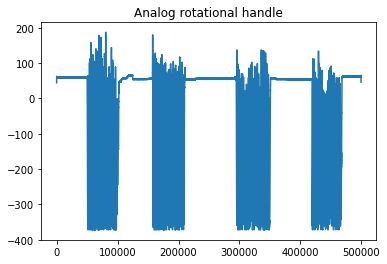

In [21]:
plt.plot(dat["BIDS_struct_save"]["data"][-1,:])
plt.title("Analog rotational handle")

Text(0.5, 1.0, 'Accelerometer')

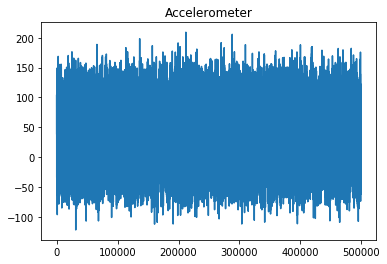

In [22]:
plt.plot(dat["BIDS_struct_save"]["data"][-7,:])
plt.title("Accelerometer")

In [23]:
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNL___01',
 'CECOG_LF_1___06___STNL___02',
 'CECOG_LF_1___07___STNL___03',
 'CECOG_LF_1___08___STNL___04',
 'CECOG_LF_1___09___EEG___01',
 'CECOG_LF_1___10___EEG___02',
 'CECOG_LF_1___11___ECOGL___01',
 'CECOG_LF_1___12___ECOGL___02',
 'CECOG_LF_1___13___ECOGL___03',
 'CECOG_LF_1___14___ECOGL___04',
 'CECOG_LF_1___15___ECOGL___05',
 'CECOG_LF_1___16___ECOGL___06',
 'CACC_2___01___Sensor_1___X',
 'CACC_2___02___Sensor_1___Y',
 'CACC_2___03___Sensor_1___Z',
 'CACC_2___04___Sensor_2___X',
 'CACC_2___05___Sensor_2___Y',
 'CACC_2___06___Sensor_2___Z',
 'CEMG_3___01___EMGright',
 'CEMG_3___02___EMGleft',
 'CEMG_3___03___EEG_CzFz',
 'CANALOG_IN_1']

In [24]:
dat["BIDS_struct_save"]["data"][0,:].shape

(499442,)

In [32]:
ch_labels = ["LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2", "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "ACC_1_X", "ACC_1_Y", "ACC_1_Z", "ACC_2_X", "ACC_2_Y", "ACC_2_Z",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "EEG_TM_CzFz", "ANALOG_ROT_R_1"]

In [33]:
#BIDS_save_493ov64_rotameterbrady_on_ref_stnr10010010001
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "003"
session = "20201107"
task = "RotameterbradyOnRefStnr"
run = "0"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [34]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=25, n_times=536676
    Range : 0 ... 536675 =      0.000 ...   390.309 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            

<ipython-input-34-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_493ov64_rotameterselfpaced_on_ref_stnr10010001

In [35]:
dat = loadmat("sub003\\BIDS_save_493ov64_rotameterselfpaced_on_ref_stnr10010001.mat")

In [36]:
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNL___01',
 'CECOG_LF_1___06___STNL___02',
 'CECOG_LF_1___07___STNL___03',
 'CECOG_LF_1___08___STNL___04',
 'CECOG_LF_1___09___EEG___01',
 'CECOG_LF_1___10___EEG___02',
 'CECOG_LF_1___11___ECOGL___01',
 'CECOG_LF_1___12___ECOGL___02',
 'CECOG_LF_1___13___ECOGL___03',
 'CECOG_LF_1___14___ECOGL___04',
 'CECOG_LF_1___15___ECOGL___05',
 'CECOG_LF_1___16___ECOGL___06',
 'CACC_2___01___Sensor_1___X',
 'CACC_2___02___Sensor_1___Y',
 'CACC_2___03___Sensor_1___Z',
 'CACC_2___04___Sensor_2___X',
 'CACC_2___05___Sensor_2___Y',
 'CACC_2___06___Sensor_2___Z',
 'CEMG_3___01___EMGright',
 'CEMG_3___02___EMGleft',
 'CEMG_3___03___EEG_CzFz',
 'CANALOG_IN_1']

In [37]:
ch_labels = ["LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2", "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "ACC_1_X", "ACC_1_Y", "ACC_1_Z", "ACC_2_X", "ACC_2_Y", "ACC_2_Z",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "EEG_TM_CzFz", "ANALOG_ROT_R_1"]

In [38]:
#BIDS_save_493ov64_rotameterselfpaced_on_ref_stnr10010001
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "003"
session = "20201107"
task = "SelfpacedOnRefSTNR110010001"
run = "1"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [39]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=25, n_times=536676
    Range : 0 ... 536675 =      0.000 ...   390.309 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            

<ipython-input-39-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)
